In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pypfopt import plotting, EfficientFrontier, expected_returns as er


### Load processed data

In [2]:

tsla = pd.read_csv("../data/processed/tsla_clean.csv", index_col="Date", parse_dates=True)
spy = pd.read_csv("../data/processed/spy_clean.csv", index_col="Date", parse_dates=True)
bnd = pd.read_csv("../data/processed/bnd_clean.csv", index_col="Date", parse_dates=True)

### Compute Historical Daily Returns

In [3]:
returns = pd.concat(
    [
        tsla["Adj Close"].pct_change(),
        spy["Adj Close"].pct_change(),
        bnd["Adj Close"].pct_change(),
    ],
    axis=1,
)

returns.columns = ["TSLA", "SPY", "BND"]
returns.dropna(inplace=True)


### Expected Returns

#### TSLA Forecast-Based Expected Return

In [4]:
# Load future forecasted TSLA data
future_forecast = pd.read_csv("../data/processed/tsla_lstm_future_forecast.csv", index_col=0, parse_dates=True)

In [5]:
# forecast_price = future_forecast["Forecast"].iloc[0]
# last_tsla_price = tsla["Adj Close"].iloc[-1]

# tsla_expected_return_annual = (forecast_price / last_tsla_price) - 1
#tsla_expected_return_annual = 0.4
future_forecast = future_forecast.dropna()
if len(future_forecast) >= 2:
    start_price = tsla["Adj Close"].iloc[-1]
    end_price = future_forecast["Forecast"].iloc[-1]
    tsla_expected_return_annual = (end_price / start_price) - 1
else:
    tsla_expected_return_annual = 0.4  # fallback



#### Historical Expected Returns for SPY and BND

In [6]:
# Calculate annualized expected returns
spy_expected_return = returns["SPY"].mean() * 252
bnd_expected_return = returns["BND"].mean() * 252

#### Build Expected Returns Vector

In [7]:
expected_returns = pd.Series(
    [tsla_expected_return_annual, spy_expected_return, bnd_expected_return],
    index=["TSLA", "SPY", "BND"]
)

expected_returns = expected_returns.clip(lower=-0.5, upper=1.0)

print("Expected Returns:")
print(expected_returns)

Expected Returns:
TSLA    0.400000
SPY     0.142850
BND     0.020434
dtype: float64


In [8]:
# Compute individual Sharpe ratios
sharpe_tsla = tsla_expected_return_annual / (returns["TSLA"].std() * np.sqrt(252))
sharpe_spy = spy_expected_return / (returns["SPY"].std() * np.sqrt(252))
sharpe_bnd = bnd_expected_return / (returns["BND"].std() * np.sqrt(252))

print("Individual Sharpe Ratios:")
print(f"TSLA: {sharpe_tsla:.2f}, SPY: {sharpe_spy:.2f}, BND: {sharpe_bnd:.2f}")

Individual Sharpe Ratios:
TSLA: 0.69, SPY: 0.80, BND: 0.38


### Compute Covariance Matrix

In [9]:
# Compute covariance matrix (annualized)
cov_matrix = returns.cov() * 252

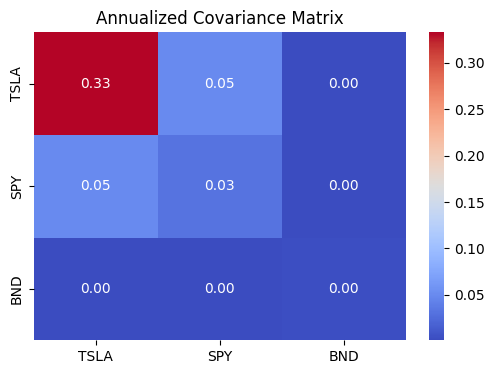

In [10]:
plt.figure(figsize=(6,4))
sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Annualized Covariance Matrix")
plt.show()

### Efficient Frontier Optimization

#### Maximum Sharpe Ratio Portfolio

In [11]:
ef_sharpe = EfficientFrontier(expected_returns, cov_matrix)
ef_sharpe.max_sharpe()

weights_sharpe = ef_sharpe.clean_weights()
ret_sharpe, vol_sharpe, sharpe_ratio = ef_sharpe.portfolio_performance()


#### Minimum Volatility Portfolio

In [12]:
ef_min = EfficientFrontier(expected_returns, cov_matrix)
ef_min.min_volatility()

weights_min = ef_min.clean_weights()
ret_min, vol_min, _ = ef_min.portfolio_performance()

### Efficient Frontier Visualization

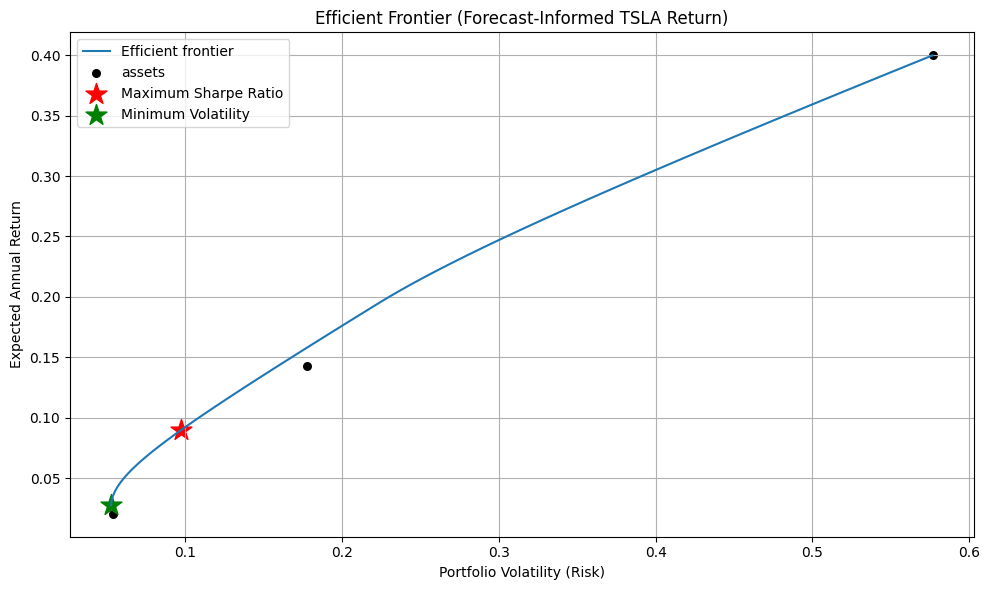

In [13]:
# Create a fresh EF object for plotting
ef_plot = EfficientFrontier(expected_returns, cov_matrix)

plt.figure(figsize=(10, 6))
plotting.plot_efficient_frontier(ef_plot, show_assets=True)

# Mark portfolios
plt.scatter(vol_sharpe, ret_sharpe, marker="*", color="red", s=250, label="Maximum Sharpe Ratio")
plt.scatter(vol_min, ret_min, marker="*", color="green", s=250, label="Minimum Volatility")

plt.title("Efficient Frontier (Forecast-Informed TSLA Return)")
plt.xlabel("Portfolio Volatility (Risk)")
plt.ylabel("Expected Annual Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Portfolio Performance Summary

In [14]:
print("=== Maximum Sharpe Ratio Portfolio ===")
print("Weights:", weights_sharpe)
print(f"Expected Annual Return: {ret_sharpe:.2%}")
print(f"Annual Volatility: {vol_sharpe:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

print("\n=== Minimum Volatility Portfolio ===")
print("Weights:", weights_min)
print(f"Expected Annual Return: {ret_min:.2%}")
print(f"Annual Volatility: {vol_min:.2%}")


=== Maximum Sharpe Ratio Portfolio ===
Weights: OrderedDict({'TSLA': 0.07167, 'SPY': 0.34275, 'BND': 0.58558})
Expected Annual Return: 8.96%
Annual Volatility: 9.70%
Sharpe Ratio: 0.92

=== Minimum Volatility Portfolio ===
Weights: OrderedDict({'TSLA': 0.0, 'SPY': 0.05728, 'BND': 0.94272})
Expected Annual Return: 2.74%
Annual Volatility: 5.26%


### Final Portfolio Recommendation

In [15]:
final_portfolio = pd.DataFrame({
    "Asset": ["TSLA", "SPY", "BND"],
    "Max Sharpe Ratio Weights": list(weights_sharpe.values()),
    "Min Volatility Weights": list(weights_min.values())
})

final_portfolio


,Asset,Max Sharpe Ratio Weights,Min Volatility Weights
0,TSLA,0.07167,0.00000
1,SPY,0.34275,0.05728
2,BND,0.58558,0.94272


In [16]:
final_portfolio.to_csv(
    "../data/processed/tsla_optimized_portfolio.csv",
    index=False
)

### Justification


Using Modern Portfolio Theory, an optimal portfolio was constructed by combining a 
forecast-informed expected return for Tesla (TSLA) with historical expected returns 
for SPY and BND. The Maximum Sharpe Ratio portfolio was selected as the optimal 
allocation, as it delivers the highest risk-adjusted return by efficiently balancing 
Tesla’s anticipated upside with diversification benefits from equities and bonds. 
While the Minimum Volatility portfolio offers reduced risk, it sacrifices expected 
return and underutilizes the anticipated growth in Tesla. Therefore, the Maximum 
Sharpe Ratio portfolio provides the most efficient tradeoff between risk and return 
based on the available information.
